In [46]:
# libraries

# for dataset
import pandas as pd
import numpy as np

# #text preprocessing
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

#ds splitting
from sklearn.model_selection import train_test_split

#ds splitting
from sklearn.feature_extraction.text import TfidfVectorizer

# rf
from sklearn.ensemble import RandomForestClassifier

# for data visualizations
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# random oversampling
from sklearn.utils import resample

# confusion metrics
import matplotlib.pyplot as plt
import seaborn as sns


# saving the model for UI
import joblib

In [47]:
# nltk

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")

[nltk_data] Downloading package punkt to C:\Users\Sherylle
[nltk_data]     Rose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sherylle
[nltk_data]     Rose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sherylle
[nltk_data]     Rose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sherylle Rose\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to C:\Users\Sherylle
[nltk_data]     Rose\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [48]:
# dataset

data = pd.read_csv("datas_labeled_checked.csv")

data = data.iloc[:, :2]
data.columns = ["Student Sentiment", "Classification"]

data.head(5)

,Student Sentiment,Classification
0,I still need practice with Java.,Weak
1,Quite easily,Strong
2,Basic to intermediate problems.,Strong
3,I feel fairly skilled.,Strong
4,I usually feel relaxed.,Strong


In [49]:
# text preprocessing

def text_preprocessing(text):
    lemmatizer = WordNetLemmatizer()
    # keep negations in stopwords
    stop_words = set(stopwords.words("english")) - {"no", "not", "don", "don’t"}

    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    word_tag_tuples = pos_tag(tokens, tagset="universal")

    tag_dict = {"NOUN": "n", "VERB": "v", "ADJ": "a", "ADV": "r"}
    final_tokens = []
    for word, tag in word_tag_tuples:
        if word not in stop_words and len(word) > 1:
            if tag in tag_dict:
                final_tokens.append(lemmatizer.lemmatize(word, tag_dict[tag]))
            else:
                final_tokens.append(lemmatizer.lemmatize(word))

    return " ".join(final_tokens)

In [50]:
# data cleaning

data.dropna(inplace=True)
data = data.drop_duplicates(subset=["Student Sentiment"])
data["Student Sentiment"] = data["Student Sentiment"].apply(text_preprocessing)

# encode sentiment labels
data["Classification"] = data["Classification"].map({"Weak": 0, "Normal": 1, "Strong": 2})

# data.head(5)

In [51]:
# to balance dataset

df_strong = data[data.Classification == 2]
df_normal = data[data.Classification == 1]
df_weak = data[data.Classification == 0]

# upsample minority classes

max_count = max(len(df_strong), len(df_normal), len(df_weak))
df_strong_up = resample(df_strong, replace=True, n_samples=max_count, random_state=42)
df_normal_up = resample(df_normal, replace=True, n_samples=max_count, random_state=42)
df_weak_up = resample(df_weak, replace=True, n_samples=max_count, random_state=42)

data_balanced = pd.concat([df_strong_up, df_normal_up, df_weak_up])

print(data_balanced["Classification"].value_counts())

Classification
2.0    607
1.0    607
0.0    607
Name: count, dtype: int64


In [52]:
# feature extraction

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X = vectorizer.fit_transform(data_balanced["Student Sentiment"])
y = data_balanced["Classification"]


In [53]:
# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [54]:
# train model

rf_model = RandomForestClassifier(
    n_estimators=1500,        # more trees for higher accuracy
    max_depth=50,             # prevent overfitting
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="log2",      
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,n_estimators,1500
,criterion,'gini'
,max_depth,50
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       121
         1.0       0.85      0.85      0.85       122
         2.0       0.89      0.80      0.84       122

    accuracy                           0.86       365
   macro avg       0.86      0.86      0.86       365
weighted avg       0.86      0.86      0.86       365


Model Accuracy: 86.30%
Precision: 86.42%
Recall: 86.30%
F1 Score: 86.21%


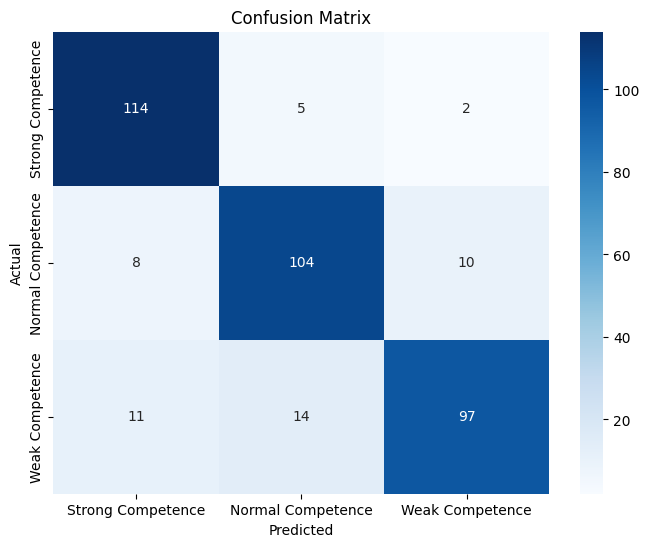

In [55]:
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nModel Accuracy: {acc * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

#confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Strong Competence', 'Normal Competence', 'Weak Competence'],
            yticklabels=['Strong Competence', 'Normal Competence', 'Weak Competence'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [56]:



joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(rf_model, "rf_model.pkl")



['rf_model.pkl']